In [1]:
#!/usr/bin/env python
# coding: utf-8

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms

# ---- My utils ----
from models import *
from utils.train_arguments import *
from utils.utils_data import *
from utils.utils_training import *

usage: ipykernel_launcher.py [-h] [--verbose]
                             [--optimizer {adam,sgd,sgd_momentum,rmsprop}]
                             [--epochs EPOCHS] [--batch_size BATCH_SIZE]
                             [--learning_rate LEARNING_RATE]
                             [--min_learning_rate MIN_LEARNING_RATE]
                             [--get_path] [--weighted_loss]
                             [--plateau_scheduler] [--steps_best]
                             [--steps_scheduler] [--binary_problem]
                             [--img_size IMG_SIZE] [--crop_size CROP_SIZE]
                             [--model_name MODEL_NAME] [--pretrained]
                             [--validation_size VALIDATION_SIZE]
                             [--output_dir OUTPUT_DIR] [--data_augmentation]
ipykernel_launcher.py: error: unrecognized arguments: -f /home/maparla/.local/share/jupyter/runtime/kernel-3db19eff-42ec-4371-838c-52c29b34c335.json


Working with Jupyter notebook! (Default Arguments)


In [2]:
args.img_size = 256
args.crop_size = 224
args.data_augmentation = True
args.pretrained = True
args.validation_size = 0.15
args.binary_problem = True

In [3]:
%matplotlib inline
import mpld3
mpld3.enable_notebook()

In [4]:
if args.data_augmentation:
    train_aug = [
        transforms.ToPILImage(),  # because the input dtype is numpy.ndarray
        transforms.Resize((args.img_size, args.img_size)),
        transforms.RandomCrop((args.crop_size, args.crop_size)),
        transforms.RandomHorizontalFlip(0.5),  # because this method is used for PIL Image dtype
        transforms.RandomVerticalFlip(0.5),  # because this method is used for PIL Image dtype
        transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
        transforms.ToTensor(),  # because inpus dtype is PIL Image
    ]
else:
    train_aug = [
        transforms.ToPILImage(),  # because the input dtype is numpy.ndarray
        transforms.Resize((args.img_size, args.img_size)),
        transforms.CenterCrop((args.crop_size, args.crop_size)),
        transforms.ToTensor(),  # because inpus dtype is PIL Image
    ]

val_aug = [
    transforms.ToPILImage(),  # because the input dtype is numpy.ndarray
    transforms.Resize((args.img_size, args.img_size)),
    transforms.CenterCrop((args.crop_size, args.crop_size)),
    transforms.ToTensor(),  # because inpus dtype is PIL Image
]

if args.pretrained:
    train_aug.append(transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]))
    val_aug.append(transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]))

# data_partition='', data_augmentation=None, validation_size=0.15, seed=42
train_dataset = SIMEPU_Dataset(data_partition='train', transform=transforms.Compose(train_aug), validation_size=args.validation_size, binary_problem=args.binary_problem)
train_loader = DataLoader(train_dataset, batch_size=args.batch_size, pin_memory=True, shuffle=True)

val_dataset = SIMEPU_Dataset(data_partition='validation', transform=transforms.Compose(val_aug), validation_size=args.validation_size, binary_problem=args.binary_problem)
val_loader = DataLoader(val_dataset, batch_size=args.batch_size, pin_memory=True, shuffle=False)

In [5]:
args.model_name = "resnet34"
model_resnet34 = model_selector(args.model_name, num_classes=train_dataset.num_classes, pretrained=args.pretrained)
model_resnet34 = torch.nn.DataParallel(model_resnet34, device_ids=range(torch.cuda.device_count()))
model_resnet34.load_state_dict(torch.load("results/resnet34_adam_256to224_lr0.0001_DA_pretrained_Binary/model_best_accuracy.pt"))

Pretrained-> Remember at end: transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm

<All keys matched successfully>

In [6]:
args.model_name = "seresnext101"
model_seresnext101 = model_selector(args.model_name, num_classes=train_dataset.num_classes, pretrained=args.pretrained)
model_seresnext101 = torch.nn.DataParallel(model_seresnext101, device_ids=range(torch.cuda.device_count()))
model_seresnext101.load_state_dict(torch.load("results/seresnext101_adam_256to224_lr0.0001_DA_pretrained_Binary/model_best_accuracy.pt"))

Pretrained-> Remember at end: transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])


<All keys matched successfully>

----------------------------------------------------------------------------------------------------------

In [7]:
model_resnet34.eval()
correct, total = 0, 0
list_outputs_resnet34, list_targets_resnet34 = [], []
with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(val_loader):
        inputs, targets = inputs.cuda(), targets.cuda()
        outputs = model_resnet34(inputs)
        list_outputs_resnet34.append(outputs)
        outputs = (nn.Sigmoid()(outputs)>0.5).float()
        targets = targets.unsqueeze(1).type_as(outputs)
        list_targets_resnet34.append(targets)

        total += targets.size(0)
        correct += (outputs == targets).float().sum().item()
print("Accuracy: {:.2f}%".format(100. * correct / total))

Accuracy: 97.79%


In [10]:
outs_resnet34 = nn.Sigmoid()(torch.cat(list_outputs_resnet34))
labels_resnet34 = torch.cat(list_targets_resnet34)
print("Outs shape: {}".format(outs_resnet34.shape))
print("Labels shape: {}".format(labels_resnet34.shape))

Outs shape: torch.Size([6709, 1])
Labels shape: torch.Size([6709, 1])


In [27]:
print("Accuracy: {:.2f}%".format((((outs_resnet34>0.5).float() == labels_resnet34).float().sum() / len(labels_resnet34)).item()*100))

Accuracy: 97.79%


----------------------------------------------------------------------------------------------------------

In [29]:
model_seresnext101.eval()
correct, total = 0, 0
list_outputs_seresnext101, list_targets_seresnext101 = [], []
with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(val_loader):
        inputs, targets = inputs.cuda(), targets.cuda()
        outputs = model_seresnext101(inputs)
        list_outputs_seresnext101.append(outputs)
        outputs = (nn.Sigmoid()(outputs)>0.5).float()
        targets = targets.unsqueeze(1).type_as(outputs)
        list_targets_seresnext101.append(targets)

        total += targets.size(0)
        correct += (outputs == targets).float().sum().item()
print("Accuracy: {:.2f}%".format(100. * correct / total))

Accuracy: 97.87%


In [30]:
outs_seresnext101 = nn.Sigmoid()(torch.cat(list_outputs_seresnext101))
labels_seresnext101 = torch.cat(list_targets_seresnext101)
print("Outs shape: {}".format(outs_seresnext101.shape))
print("Labels shape: {}".format(labels_seresnext101.shape))

Outs shape: torch.Size([6709, 1])
Labels shape: torch.Size([6709, 1])


In [32]:
print("Accuracy: {:.2f}%".format((((outs_seresnext101>0.5).float() == labels_seresnext101).float().sum() / len(labels_seresnext101)).item()*100))

Accuracy: 97.87%


----------------------------------------------------------------------------------------------------------

In [42]:
outs_ensemble = (outs_seresnext101*0.55 + outs_resnet34+0.45) / 2
accuracy_ensemble = ((outs_ensemble > 0.5).float() == labels_resnet34).float().sum() / len(labels_resnet34)
print("Accuracy: {:.2f}%".format(accuracy_ensemble*100))

Accuracy: 98.03%


----------------------------------------------------------------------------------------------------------

## ROC

In [46]:
def H(clientes, impostores):
    """
    Se itera sobre los escores de clientes e impostores y vamos sumando
        1 si c>i
        0.5 si c==i
        0 si i>c
    """
    compt_sum = 0
    for c in clientes:
        for i in impostores:
            if c>i:
                compt_sum+=1
            elif c==i:
                compt_sum+=0.5
    return compt_sum

In [47]:
# Recuperamos los puntos que forman la curva ROC de los diferentes supuestos
def aroc(clientes, impostores):
    return 1/(len(clientes)*len(impostores)) * H(clientes, impostores)

In [53]:
# Calcular el valor aproximado de Verdaderos positivos dado ratio de Falsos Positivos
def TPwithFP(tp_rates, fp_rates, fp_ratio, return_dist=False):
    res, dist = 0, 99999
    
    index_sort_fp = np.argsort(fp_rates)
    fp_rate_sorted = fp_rates[index_sort_fp]
    
    for idx, val in enumerate(fp_rate_sorted):
        if abs(val-fp_ratio)<dist:
            res = idx
            dist = abs(val-fp_ratio)
            
        if abs(val-fp_ratio)>dist: # Al estar ordenado, si nos distanciamos debemos parar
            break
        
    if return_dist: return res, dist
    return tp_rates[index_sort_fp][res]

#### ResNet34

In [58]:
# No Daño clase 0 / Daño clase 1
true_positives_resnet34, false_positives_resnet34 = [], []
for umbral in np.unique(outs_resnet34.data.cpu().numpy()):
    
    # Los verdadderos son aquellos que tienen daño y son clasificados como que tienen (correctamente)
    true_positives_resnet34.append( int((outs_resnet34[labels_resnet34==1] > umbral).float().sum().item()) / len(outs_resnet34[labels_resnet34==1]) )
    
    # Los falsos positivos son aquellos No daño que tienen un valor mayor stricto que el umbral
    # Positivos que deberian haber sido negativos (por eso falsos) porque se trata de No Daño!
    false_positives_resnet34.append( int((outs_resnet34[labels_resnet34==0] > umbral).float().sum().item()) / len(outs_resnet34[labels_resnet34==0]) )

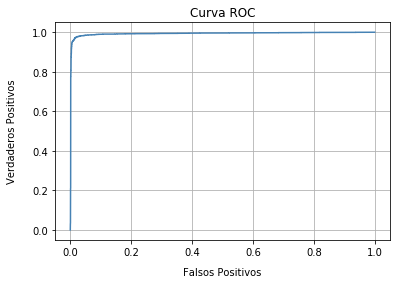

In [59]:
# Vamos a visualizar los resultados obtenidos
plt.plot(false_positives_resnet34, true_positives_resnet34, 'steelblue')

plt.title("Curva ROC")
plt.ylabel("Verdaderos Positivos", labelpad=15)
plt.xlabel("Falsos Positivos", labelpad=10)

plt.grid()
#plt.savefig('curva_ROC.eps', bbox_inches = 'tight')

In [60]:
print("Area bajo curva ROC: {:.4f}".format(aroc( outs_resnet34[labels_resnet34==1].data.cpu().numpy(), outs_resnet34[labels_resnet34==0].data.cpu().numpy() )))
for rat in [0.1, 0.01, 0.005, 0.004, 0.003, 0.002, 0.001]:
    tp = TPwithFP(np.array(true_positives_resnet34), np.array(false_positives_resnet34), fp_ratio=rat)
    print( "True Positive {:.2f}% para FP ratio {:.2f}%".format(tp*100, rat*100) )

Area bajo curva ROC: 0.9932
True Positive 98.97% para FP ratio 10.00%
True Positive 95.84% para FP ratio 1.00%
True Positive 94.49% para FP ratio 0.50%
True Positive 92.30% para FP ratio 0.40%
True Positive 88.99% para FP ratio 0.30%
True Positive 80.38% para FP ratio 0.20%
True Positive 38.92% para FP ratio 0.10%


----------------------------------------------------------------------------------------------------------

#### Seresnext101

In [61]:
# No Daño clase 0 / Daño clase 1
true_positives_seresnext101, false_positives_seresnext101 = [], []
for umbral in np.unique(outs_seresnext101.data.cpu().numpy()):
    
    # Los verdadderos son aquellos que tienen daño y son clasificados como que tienen (correctamente)
    true_positives_seresnext101.append( int((outs_seresnext101[labels_seresnext101==1] > umbral).float().sum().item()) / len(outs_seresnext101[labels_seresnext101==1]) )
    
    # Los falsos positivos son aquellos No daño que tienen un valor mayor stricto que el umbral
    # Positivos que deberian haber sido negativos (por eso falsos) porque se trata de No Daño!
    false_positives_seresnext101.append( int((outs_seresnext101[labels_seresnext101==0] > umbral).float().sum().item()) / len(outs_seresnext101[labels_seresnext101==0]) )

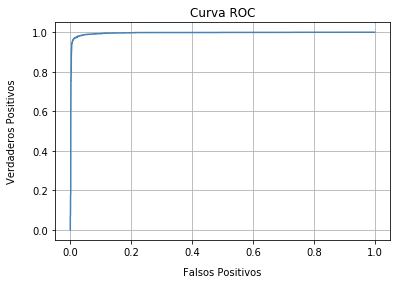

In [64]:
# Vamos a visualizar los resultados obtenidos
plt.plot(false_positives_seresnext101, true_positives_seresnext101, 'steelblue')

plt.title("Curva ROC")
plt.ylabel("Verdaderos Positivos", labelpad=15)
plt.xlabel("Falsos Positivos", labelpad=10)

plt.grid()
#plt.savefig('curva_ROC.eps', bbox_inches = 'tight')

In [63]:
print("Area bajo curva ROC: {:.4f}".format(aroc( outs_seresnext101[labels_seresnext101==1].data.cpu().numpy(), outs_seresnext101[labels_seresnext101==0].data.cpu().numpy() )))
for rat in [0.1, 0.01, 0.005, 0.004, 0.003, 0.002, 0.001]:
    tp = TPwithFP(np.array(true_positives_seresnext101), np.array(false_positives_seresnext101), fp_ratio=rat)
    print( "True Positive {:.2f}% para FP ratio {:.2f}%".format(tp*100, rat*100) )

Area bajo curva ROC: 0.9955
True Positive 99.28% para FP ratio 10.00%
True Positive 96.37% para FP ratio 1.00%
True Positive 94.27% para FP ratio 0.50%
True Positive 90.77% para FP ratio 0.40%
True Positive 83.48% para FP ratio 0.30%
True Positive 61.70% para FP ratio 0.20%
True Positive 17.83% para FP ratio 0.10%


----------------------------------------------------------------------------------------------------------

In [66]:
# No Daño clase 0 / Daño clase 1
true_positives_ensemble, false_positives_ensemble = [], []
for umbral in np.unique(outs_ensemble.data.cpu().numpy()):
    
    # Los verdadderos son aquellos que tienen daño y son clasificados como que tienen (correctamente)
    true_positives_ensemble.append( int((outs_ensemble[labels_resnet34==1] > umbral).float().sum().item()) / len(outs_ensemble[labels_resnet34==1]) )
    
    # Los falsos positivos son aquellos No daño que tienen un valor mayor stricto que el umbral
    # Positivos que deberian haber sido negativos (por eso falsos) porque se trata de No Daño!
    false_positives_ensemble.append( int((outs_ensemble[labels_resnet34==0] > umbral).float().sum().item()) / len(outs_ensemble[labels_resnet34==0]) )

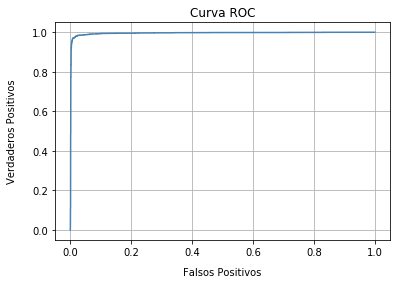

In [67]:
# Vamos a visualizar los resultados obtenidos
plt.plot(false_positives_ensemble, true_positives_ensemble, 'steelblue')

plt.title("Curva ROC")
plt.ylabel("Verdaderos Positivos", labelpad=15)
plt.xlabel("Falsos Positivos", labelpad=10)

plt.grid()
#plt.savefig('curva_ROC.eps', bbox_inches = 'tight')

In [68]:
print("Area bajo curva ROC: {:.4f}".format(aroc( outs_ensemble[labels_resnet34==1].data.cpu().numpy(), outs_ensemble[labels_resnet34==0].data.cpu().numpy() )))
for rat in [0.1, 0.01, 0.005, 0.004, 0.003, 0.002, 0.001]:
    tp = TPwithFP(np.array(true_positives_ensemble), np.array(false_positives_ensemble), fp_ratio=rat)
    print( "True Positive {:.2f}% para FP ratio {:.2f}%".format(tp*100, rat*100) )

Area bajo curva ROC: 0.9954
True Positive 99.31% para FP ratio 10.00%
True Positive 96.96% para FP ratio 1.00%
True Positive 95.15% para FP ratio 0.50%
True Positive 94.18% para FP ratio 0.40%
True Positive 92.18% para FP ratio 0.30%
True Positive 79.16% para FP ratio 0.20%
True Positive 44.12% para FP ratio 0.10%
